# PART 2: MACHINE LEARNING FORECAST

## 2.1. Data preparation

In [ ]:
# Import data
data = pd.read_csv('norway_new_car_sales_by_make.csv')
data.head()

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5


In [ ]:
# Process data
def import_data():
  data = pd.read_csv('norway_new_car_sales_by_make.csv')
  data['Period'] = data['Year'].astype(str) + '-' + data['Month'].astype(str).str.zfill(2)
  df = pd.pivot_table(data = data, values = 'Quantity', index = 'Make', columns = 'Period', aggfunc = 'sum', fill_value = 0)
  return df

df = import_data()
df.head()

Period,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,...,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01
Make,,,,,,,,,,,,,,,,,,,,,
Alfa Romeo,16,9,21,20,17,21,14,12,15,10,...,3,1,2,1,6,15,3,4,3,6
Aston Martin,0,0,1,0,4,3,3,0,0,0,...,0,0,1,0,0,0,0,0,0,0
Audi,599,498,682,556,630,498,562,590,393,554,...,685,540,551,687,794,688,603,645,827,565
BMW,352,335,365,360,431,477,403,348,271,562,...,1052,832,808,636,1031,1193,1096,1663,866,1540
Bentley,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,1,0,0,0,0,0


## 2.2. Create train set and test set

In [ ]:
def datasets(df, x_len = 12, y_len = 1, test_loops = 12):
  D = df.values
  rows, periods = D.shape

  # Create train set
  loops = periods + 1 - x_len - y_len
  train = []
  for col in range(loops):
    train.append(D[:, col:col+x_len+y_len])
  train = np.vstack(train)
  X_train, Y_train = np.split(train, [-y_len], axis = 1)

  # Create test set
  if test_loops > 0:
    X_train, X_test = np.split(X_train, [-rows*test_loops], axis=0)
    Y_train, Y_test = np.split(Y_train, [-rows*test_loops], axis=0)
  else: # If there is no test set, X_test is used to generate the future forecast
    X_test = D[:, -x_len:]
    Y_test = np.full((X_test.shape[0], y_len), np.nan)

  # Reformat to meet sklearn requirement
  if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()

  # Return test set and train set
  return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = datasets(df)

## 2.3. ML Forecasting KPIs

In [ ]:
def kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = ''):
  df = pd.DataFrame(columns = ['MAE', 'RMSE', 'Bias'], index=['Train', 'Test'])
  df.index.name = name
  df.loc['Train', 'MAE'] = 100*np.mean(abs(Y_train - Y_train_pred))/np.mean(Y_train)
  df.loc['Train','RMSE'] = 100*np.sqrt(np.mean((Y_train - Y_train_pred)**2))/np.mean(Y_train)
  df.loc['Train','Bias'] = 100*np.mean((Y_train - Y_train_pred))/np.mean(Y_train)
  df.loc['Test','MAE'] = 100*np.mean(abs(Y_test - Y_test_pred))/np.mean(Y_test)
  df.loc['Test','RMSE'] = 100*np.sqrt(np.mean((Y_test - Y_test_pred)**2))/np.mean(Y_test)
  df.loc['Test','Bias'] = 100*np.mean((Y_test - Y_test_pred))/np.mean(Y_test)
  df = df.astype(float).round(1)
  print(df)

## 2.4. Linear Regression

In [ ]:
# Import package
from sklearn.linear_model import LinearRegression

# Setup linear regression model
reg = LinearRegression()

# Fit train set into the model
reg = reg.fit(X_train, Y_train)

# Predict for train set and test set
Y_train_pred = reg.predict(X_train)
Y_test_pred = reg.predict(X_test)

# Forecast KPIs
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Regression')

             MAE  RMSE  Bias
Regression                  
Train       17.8  43.9   0.0
Test        17.8  43.7   1.6


## 2.5. Decision Tree

In [ ]:
# Import package
from sklearn.tree import DecisionTreeRegressor

# Setup Decision Tree Regressor model
tree = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5)

# Fit train set into the model
tree.fit(X_train, Y_train)

# Predict for train set and test set
Y_train_pred = tree.predict(X_train)
Y_test_pred = tree.predict(X_test)

# Forecast KPIs
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

        MAE  RMSE  Bias
Tree                   
Train  18.1  43.4  -0.0
Test   21.1  52.6   3.2


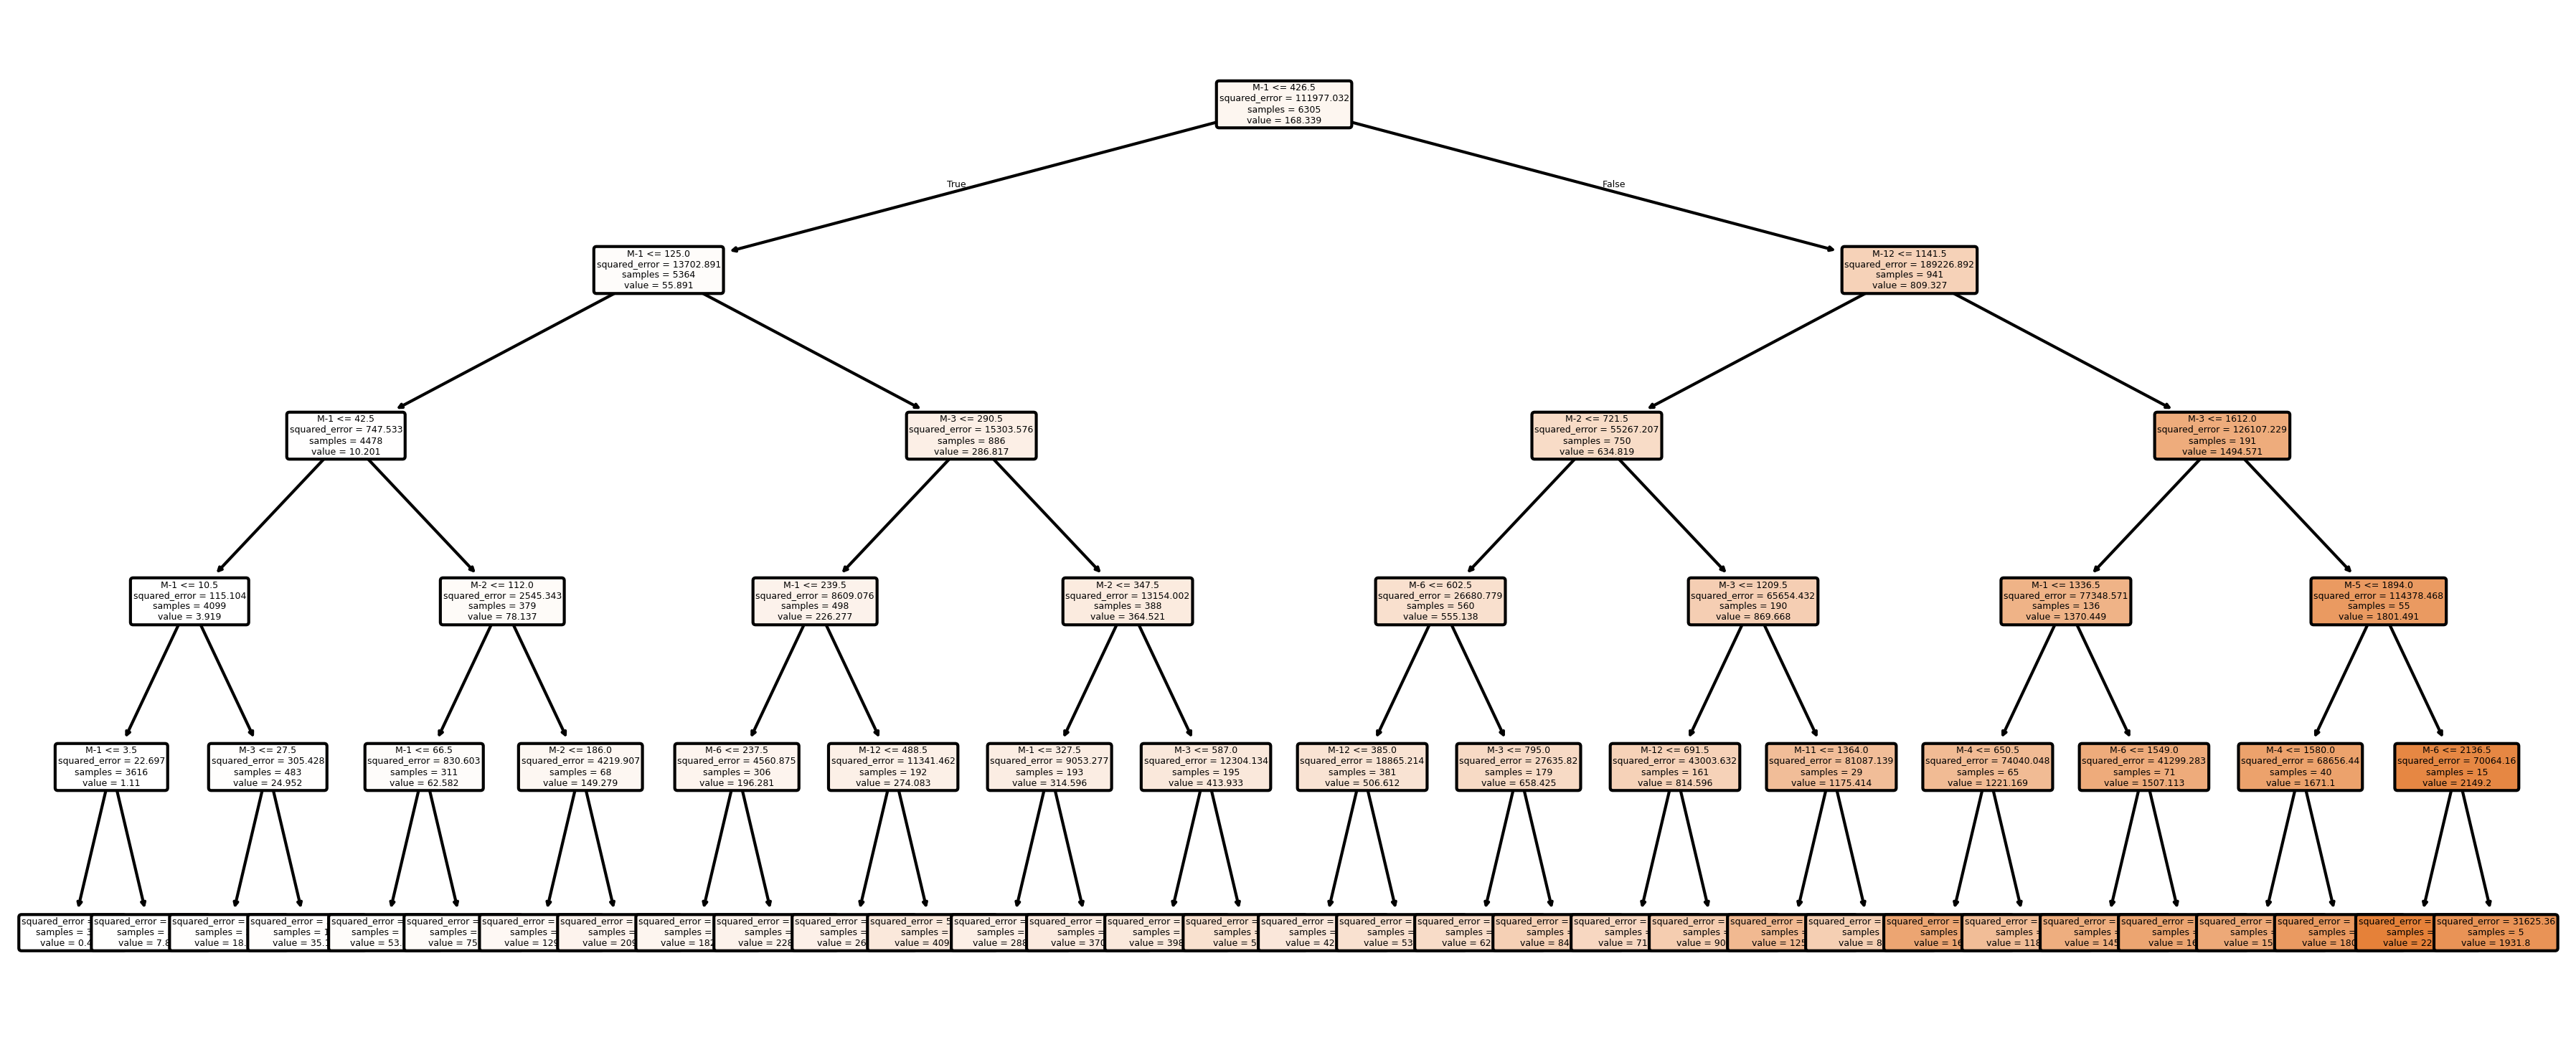

In [ ]:
# Visualize the tree
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,6), dpi=300)
ax = fig.gca()
plot_tree(tree, fontsize = 3, feature_names=[f'M{x-12}' for x in range(12)],
          rounded = True, filled = True, ax = ax)
fig.savefig('Regression Tree.PNG')

In [ ]:
# Compare training time when using different criterion
import time
for criterion in ['squared_error', 'absolute_error']:
  start_time = time.time()
  tree = DecisionTreeRegressor(max_depth = 5, min_samples_split = 15, min_samples_leaf = 5, criterion = criterion)
  tree.fit(X_train, Y_train)
  Y_train_pred = tree.predict(X_train)
  Y_test_pred = tree.predict(X_test)

  kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = f'Tree {criterion}')
  print('{:0.2f} seconds'.format(time.time() - start_time))
  print()

                     MAE  RMSE  Bias
Tree squared_error                  
Train               18.1  43.4  -0.0
Test                21.1  52.6   3.2
0.15 seconds

                      MAE  RMSE  Bias
Tree absolute_error                  
Train                17.9  47.0   2.3
Test                 21.5  58.5   5.2
4.99 seconds



## 2.6. Parameter Optimization (Decision Tree examples)

In [ ]:
# K-fold cross-validation random search

# Create a dictionary containing value of test parameter
max_depth = list(range(5,11)) + [None]
min_samples_split = range(5,20)
min_samples_leaf = range(2,20)

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

# Import package and setup model
from sklearn.model_selection import RandomizedSearchCV
tree = DecisionTreeRegressor()

# Apply the random search with MAE scoring to the tree model
tree_cv = RandomizedSearchCV(tree, param_dist, n_jobs = -1, cv = 10,
                             verbose = 1, n_iter = 100, scoring = 'neg_mean_absolute_error')
tree_cv.fit(X_train, Y_train)
print('Tuned Regression Tree Parameters:', tree_cv.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Tuned Regression Tree Parameters: {'min_samples_split': 12, 'min_samples_leaf': 18, 'max_depth': 7}


In [ ]:
# Use the tuned model to predict train set and test set
Y_train_pred = tree_cv.predict(X_train)
Y_test_pred = tree_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Tree')

        MAE  RMSE  Bias
Tree                   
Train  16.8  41.4   0.0
Test   18.1  45.5   3.1


In [ ]:
# Check the detail random search result
cv_result = pd.DataFrame(tree_cv.cv_results_)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.083480,0.022574,0.005427,0.004894,7,8,7,"{'min_samples_split': 7, 'min_samples_leaf': 8...",-33.733091,-34.650339,...,-28.876694,-31.253861,-31.115026,-37.685300,-40.443780,-35.763610,-37.539940,-34.880016,3.458096,44
1,0.094011,0.048210,0.003262,0.002154,19,14,8,"{'min_samples_split': 19, 'min_samples_leaf': ...",-32.045885,-32.635675,...,-29.588611,-31.182986,-32.275739,-38.253295,-42.163032,-33.859497,-38.588716,-35.073223,4.098992,52
2,0.060458,0.015035,0.002583,0.001125,14,13,7,"{'min_samples_split': 14, 'min_samples_leaf': ...",-31.186034,-33.394862,...,-28.373929,-30.935354,-30.897613,-37.919692,-40.187413,-32.455260,-38.426460,-34.193896,3.892699,7
3,0.063522,0.018995,0.006042,0.004685,19,6,5,"{'min_samples_split': 19, 'min_samples_leaf': ...",-32.906281,-33.191062,...,-29.553016,-33.052256,-32.843344,-35.915223,-38.942488,-35.391676,-41.220549,-35.268112,3.493499,63
4,0.072099,0.014335,0.004770,0.003285,7,14,6,"{'min_samples_split': 7, 'min_samples_leaf': 1...",-31.276258,-32.262953,...,-29.262141,-29.776639,-32.878077,-37.475555,-40.851821,-32.796636,-39.175636,-34.463303,4.011020,22


## 2.7. Random Forest

In [ ]:
# Import package and setup model
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(bootstrap = True, max_samples = 0.95,
                               max_features = 11, min_samples_leaf = 18, max_depth = 7)

# Fit train set into the model
forest.fit(X_train, Y_train)

RandomForestRegressor(max_depth=7, max_features=11, max_samples=0.95,
                      min_samples_leaf=18)

In [ ]:
# Predict train set and test set
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'Forest')

         MAE  RMSE  Bias
Forest                  
Train   15.7  40.0  -0.1
Test    18.3  47.0   3.7


In [ ]:
# Apply the random search with MAE scoring to the forest model
max_depth = list(range(5,11)) + [None]
min_samples_split = range(5, 20)
min_samples_leaf = range(2, 15)
max_features = range(3, 8)
bootstrap = [True]
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

forest = RandomForestRegressor(n_jobs = 1, n_estimators = 30)
forest_cv = RandomizedSearchCV(forest, param_dist, cv = 6, n_jobs = -1,
                               verbose = 2, n_iter = 400, scoring = 'neg_mean_absolute_error')

# Use the tuned model to predict train and test set
forest_cv.fit(X_train, Y_train)
print('Tuned Forest Parameters:', forest_cv.best_params_)

Fitting 6 folds for each of 400 candidates, totalling 2400 fits
Tuned Forest Parameters: {'min_samples_split': 13, 'min_samples_leaf': 7, 'max_samples': 0.7, 'max_features': 5, 'max_depth': 7, 'bootstrap': True}


In [ ]:
# Use the tuned model to predict train set and test set
Y_train_pred = forest_cv.predict(X_train)
Y_test_pred = forest_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forest optimized')

                   MAE  RMSE  Bias
Forest optimized                  
Train             15.2  38.2   0.2
Test              18.0  46.4   3.4


In [ ]:
# Setup the forest model with tuned parameters and adjust n_estimateors = 200
forest = RandomForestRegressor(n_estimators = 200, n_jobs = -1, **forest_cv.best_params_)
forest = forest.fit(X_train, Y_train)

# Use the tuned model to predict train set and test set
Y_train_pred = forest.predict(X_train)
Y_test_pred = forest.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='Forestx200')

             MAE  RMSE  Bias
Forestx200                  
Train       15.0  37.8   0.0
Test        17.8  45.7   3.1


## 2.8. Feature Importance (Random Forest examples)

<Axes: >

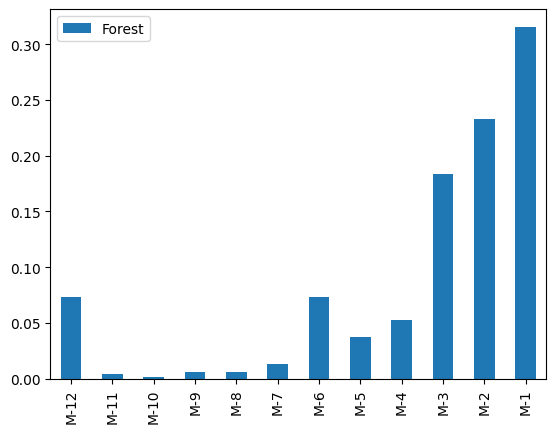

In [ ]:
# Number of train features
cols = X_train.shape[1]

# Get the feature list
features = [f'M-{cols-col}' for col in range(cols)]

# Create the feature importance dataframe
feature_importance = pd.DataFrame(data = forest.feature_importances_.reshape(-1,1),
                                  index = features,
                                  columns=['Forest'])

# Visualize the feature importance chart
feature_importance.plot(kind='bar')

## 2.9. Extremely Randomized Trees

In [ ]:
# Import the package
from sklearn.ensemble import ExtraTreesRegressor

# Setup the model
ETR = ExtraTreesRegressor(n_jobs = -1, n_estimators = 200, min_samples_split = 15,
                          min_samples_leaf = 4, max_samples = 0.95, max_features = 4,
                          max_depth = 8, bootstrap = True)

# Fit train set to the model
ETR.fit(X_train,Y_train)

ExtraTreesRegressor(bootstrap=True, max_depth=8, max_features=4,
                    max_samples=0.95, min_samples_leaf=4, min_samples_split=15,
                    n_estimators=200, n_jobs=-1)

In [ ]:
# Use the model to predict train and test sets
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR')

        MAE  RMSE  Bias
ETR                    
Train  18.0  43.4   0.1
Test   18.9  46.7   3.3


In [ ]:
# Optimize the model using random search
max_depth = list(range(6,13)) + [None]
min_samples_split = range(7,16)
min_samples_leaf = range(2,13)
max_features = range(5,13)
bootstrap = [True]
max_samples = [.7,.8,.9,.95,1]

param_dist = {'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'bootstrap': bootstrap,
              'max_samples': max_samples}

ETR = ExtraTreesRegressor(n_jobs = 1, n_estimators = 30)
ETR_cv = RandomizedSearchCV(ETR, param_dist, cv = 5, verbose = 2,  n_jobs = -1,
                            n_iter = 400, scoring = 'neg_mean_absolute_error')
ETR_cv.fit(X_train,Y_train)

print('Tuned Forest Parameters:', ETR_cv.best_params_)
print()


Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Tuned Forest Parameters: {'min_samples_split': 7, 'min_samples_leaf': 4, 'max_samples': 0.95, 'max_features': 12, 'max_depth': 11, 'bootstrap': True}



In [ ]:
# Use the tuned model to predict train and test sets
Y_train_pred = ETR_cv.predict(X_train)
Y_test_pred = ETR_cv.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name = 'ETR optimized')

                MAE  RMSE  Bias
ETR optimized                  
Train          14.2  35.6   0.1
Test           17.4  44.3   2.5


In [ ]:
# Run the tuned model with 200 trees
ETR = ExtraTreesRegressor(n_estimators = 200, n_jobs = -1, **ETR_cv.best_params_).fit(X_train, Y_train)
Y_train_pred = ETR.predict(X_train)
Y_test_pred = ETR.predict(X_test)
kpi_ML(Y_train, Y_train_pred, Y_test, Y_test_pred, name='ETR x200')

           MAE  RMSE  Bias
ETR x200                  
Train     14.1  35.6  -0.1
Test      17.4  44.5   2.4


## 2.9. Feature Optimization #1 (Random Forest and Extremely Randomized Trees examples)

In [ ]:
# Get the dataframe
df = import_data()

# Forest features dictionary and model
forest_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split': 15,
                   'min_samples_leaf': 4, 'max_samples': 0.95, 'max_features': 0.3,
                   'max_depth': 8, 'bootstrap':True}
forest = RandomForestRegressor(**forest_features)

# ERT features dictionary and model
ETR_features = {'n_jobs':-1, 'n_estimators':200, 'min_samples_split':14,
                'min_samples_leaf':2, 'max_samples':0.9, 'max_features':1.0,
                'max_depth': 12, 'bootstrap':True}

ETR = ExtraTreesRegressor(**ETR_features)

# List of models
models = [('Forest', forest), ('ETR', ETR)]


In [ ]:
# Function to return MAE
def model_mae(model, X, Y):
  Y_pred = model.predict(X)
  mae = np.mean(np.abs(Y - Y_pred))/np.mean(Y)
  return mae

<Axes: xlabel='Number of months'>

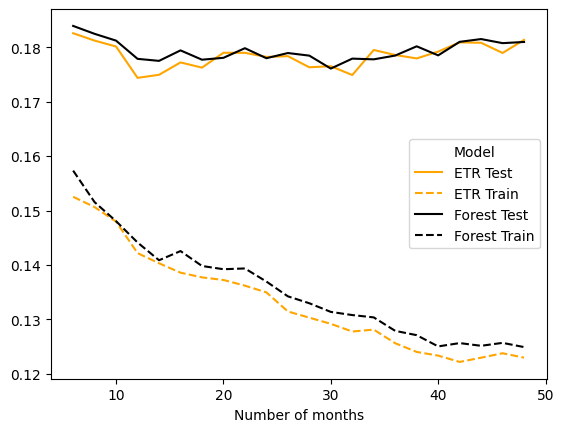

In [ ]:
# Determine the optimal number of month (feature) using train set

# from 6 to 50 months with 2 gap
n_months = range(6,50,2)

# Empty list to store the result
results = []

# Loop for testing
for x_len in n_months:
  X_train, Y_train, X_test, Y_test = datasets(df, x_len = x_len)
  for name, model in models:
    model.fit(X_train, Y_train)
    mae_train = model_mae(model, X_train, Y_train)
    mae_test = model_mae(model, X_test, Y_test)
    results.append([name + ' Train', mae_train, x_len])
    results.append([name + ' Test', mae_test, x_len])

# Format the result to visualize
data = pd.DataFrame(results, columns=['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level = 1)
data.index.name = 'Number of months'

# Visualize the result
data.plot(color = ['orange']*2+['black']*2, style = ['-','--']*2)

In [ ]:
# Print the optimal number of feature
print(data.idxmin())

Model
ETR Test        12
ETR Train       42
Forest Test     30
Forest Train    48
dtype: int64


In [ ]:
# Determine the optimal number of month (feature) using K-fold cross-validation

# Import package
from sklearn.model_selection import KFold

# Empty list for storing the result
results = []

# Loop through each number of feature option
for x_len in n_months:
  X_train, Y_train, X_test, Y_test = datasets(df, x_len = x_len)
  for name, model in models:
    mae_kfold_train = []
    mae_kfold_val = []

    # Split the train set into k folds
    for train_index, val_index in KFold(n_splits = 8).split(X_train):
      X_train_kfold, X_val_kfold = X_train[train_index], X_train[val_index]
      Y_train_kfold, Y_val_kfold = Y_train[train_index], Y_train[val_index]

      # Fit each fold into model
      model.fit(X_train_kfold, Y_train_kfold)

      # Calculate mae train and append into the list
      mae_train = model_mae(model, X_train_kfold, Y_train_kfold)
      mae_kfold_train.append(mae_train)

      # Calculate mae val and append into the list
      mae_val = model_mae(model, X_val_kfold, Y_val_kfold)
      mae_kfold_val.append(mae_val)

    # Append list into result
    results.append([name + ' Val', np.mean(mae_kfold_val), x_len])
    results.append([name + ' Train', np.mean(mae_kfold_train), x_len])

    # Fit the whole train and test sets into the model to compare with folds result
    model.fit(X_train, Y_train)
    mae_test = model_mae(model, X_test, Y_test)
    results.append([name + ' Test', mae_test, x_len])


Model
ETR Test        12
ETR Train       40
ETR Val         40
Forest Test     16
Forest Train    44
Forest Val      48
dtype: int64


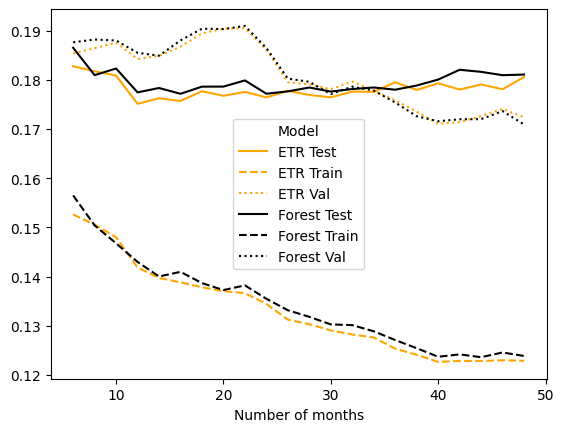

In [ ]:
# Visualize the result and print the optimal number of feature
data = pd.DataFrame(results, columns = ['Model', 'MAE%', 'Number of Months'])
data = data.set_index(['Number of Months', 'Model']).stack().unstack('Model')
data.index = data.index.droplevel(level = 1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3, style=['-', '--', ':']*2)
print(data.idxmin())


In [ ]:
# Determine the optimal number of month (feature) using holdout set (pre-test set/ second test set)

def datasets_holdout(df, x_len=12, y_len = 1, test_loops = 12, holdout_loops = 0):
  D = df.values
  rows, periods = D.shape

  # Training set creation
  train_loops = periods + 1 - x_len - y_len - test_loops
  train = []
  for col in range(train_loops):
    train.append(D[:,col:col+x_len+y_len])
  train = np.vstack(train)
  X_train, Y_train = np.split(train, [-y_len], axis = 1)

  # Holdout set creation
  if holdout_loops > 0:
    X_train, X_holdout = np.split(X_train,[-rows*holdout_loops], axis=0)
    Y_train, Y_holdout = np.split(Y_train,[-rows*holdout_loops], axis=0)
  else:
    X_holdout, Y_holdout = np.array([]), np.array([])

  # Test set creation
  if test_loops > 0:
    X_train, X_test = np.split(X_train,[-rows*test_loops],axis=0)
    Y_train, Y_test = np.split(Y_train,[-rows*test_loops],axis=0)
  else: # No test set: X_test is used to generate the future forecast
    X_test = D[:,-x_len:]
    Y_test = np.full((X_test.shape[0],y_len),np.nan) #Dummy value

  # Formatting required for scikit-learn
  if y_len == 1:
    Y_train = Y_train.ravel()
    Y_test = Y_test.ravel()
    Y_holdout = Y_holdout.ravel()

  return X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test

In [ ]:
 results = []
 for x_len in n_months:
  X_train, Y_train, X_holdout, Y_holdout, X_test, Y_test = datasets_holdout(df, x_len=x_len, holdout_loops=12)
  for name, model in models:
    model.fit(X_train,Y_train)
    mae_train = model_mae(model, X_train, Y_train)
    mae_holdout = model_mae(model, X_holdout, Y_holdout)
    mae_test = model_mae(model, X_test, Y_test)
    results.append([name+' Train',mae_train,x_len])
    results.append([name+' Test',mae_test,x_len])
    results.append([name+' Holdout',mae_holdout,x_len])


Model
ETR Holdout       20
ETR Test          12
ETR Train         40
Forest Holdout    26
Forest Test       12
Forest Train      40
dtype: int64


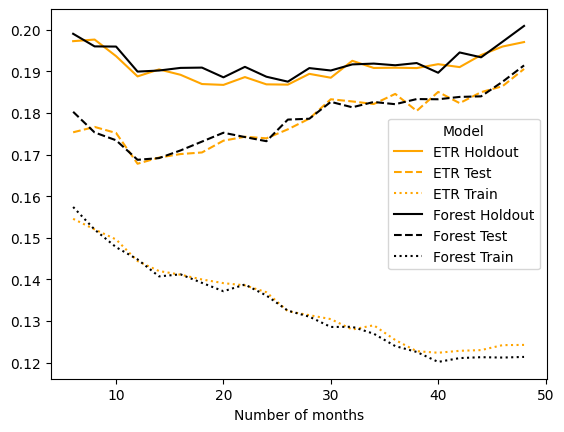

In [ ]:
data = pd.DataFrame(results,columns=['Model','MAE%','Number of Months'])
data = data.set_index(['Number of Months','Model']).stack().unstack('Model')
data.index = data.index.droplevel(level=1)
data.index.name = 'Number of months'
data.plot(color=['orange']*3+['black']*3,style=['-','--',':']*3)
print(data.idxmin())

## 2.10. Adaptive Boosting